# Setup

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

import os
import time
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Set Seed and Device

In [2]:
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
device

device(type='cuda')

### Loading dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/dataset_horse_vs_panda/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/dataset_horse_vs_panda/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the train and test functions

In [6]:
def test(model, data_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        accuracy = running_corrects.double() / len(data_loader.dataset)
    return accuracy

In [7]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=10, model_name="model"):
    writer = SummaryWriter(log_dir=f"runs/{model_name}")

    step=0
    model.train()
    loss_history = []
    train_accuracy_hist = []
    test_accuracy_hist = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_accuracy = test(model, train_loader, criterion, device)
            test_accuracy = test(model, test_loader, criterion, device)
            writer.add_scalar("Loss/train", loss.item(), step)
            writer.add_scalar("Accuracy/train", train_accuracy, step)
            writer.add_scalar("Accuracy/test", test_accuracy, step)
            step += 1
        loss_history.append(running_loss / len(train_loader))
        train_accuracy_hist.append(train_accuracy)
        test_accuracy_hist.append(test_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs} Loss: {running_loss / len(train_loader)} Training Accuracy: {train_accuracy} Test Accuracy: {test_accuracy}")
    writer.close()
    return loss_history, train_accuracy_hist, test_accuracy_hist

### Function for Plotting Results

In [14]:
def plot_data(loss):
  for i in range(len(loss[0])):
      loss[1][i] = loss[1][i].item()
      loss[2][i] = loss[2][i].item()
  plt.figure(figsize = (10,5))
  plt.subplot(1,2,1)
  plt.plot(loss[0])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title('Loss vs Epochs')
  plt.subplot(1,2,2)
  plt.plot(loss[1], label='train')
  plt.plot(loss[2], label='test')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title('Accuracy vs Epoch')
  plt.legend()
  plt.show()

# VGG (1 Block)

### Define Model Architecture

In [35]:
class vgg_1_block(nn.Module):
    def __init__(self):
        super(vgg_1_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

vgg1b = vgg_1_block().to(device)
print(vgg1b)
num_params_vgg1b = sum(p.numel() for p in vgg1b.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params_vgg1b}')

vgg_1_block(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters: 51381506


### Train the model

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg1b.parameters(), lr=0.001)
start_time = time.time()
vgg1b_items = train(vgg1b, train_loader, loss_fn, optimizer, device, num_epochs=10, model_name = "vgg1b")
end_time = time.time()
vgg1b_time = end_time - start_time
print(f"Training time: {vgg1b_time}")
vgg1b_test_accuracy = test(vgg1b, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 1 Block = {vgg1b_test_accuracy}")
vgg1b_train_accuracy = test(vgg1b, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 1 Block = {vgg1b_train_accuracy}")
torch.save(vgg1b.state_dict(), 'vgg1b.pt')

Epoch 1/10 Loss: 14.391813838481903 Training Accuracy: 0.7562500000000001 Test Accuracy: 0.5750000000000001
Epoch 2/10 Loss: 5.660730338096618 Training Accuracy: 0.9 Test Accuracy: 0.8250000000000001
Epoch 3/10 Loss: 1.5097364068031311 Training Accuracy: 0.9500000000000001 Test Accuracy: 0.775
Epoch 4/10 Loss: 0.8440433472394944 Training Accuracy: 0.9625 Test Accuracy: 0.7250000000000001
Epoch 5/10 Loss: 0.03530962634831667 Training Accuracy: 1.0 Test Accuracy: 0.8500000000000001
Epoch 6/10 Loss: 0.00034116124488718923 Training Accuracy: 0.99375 Test Accuracy: 0.8250000000000001
Epoch 7/10 Loss: 0.005312156055877893 Training Accuracy: 0.99375 Test Accuracy: 0.8
Epoch 8/10 Loss: 0.027654087985137375 Training Accuracy: 1.0 Test Accuracy: 0.8250000000000001
Epoch 9/10 Loss: 0.008326036227879285 Training Accuracy: 1.0 Test Accuracy: 0.8250000000000001
Epoch 10/10 Loss: 0.00013083023946478534 Training Accuracy: 1.0 Test Accuracy: 0.8250000000000001
Training time: 64.08882641792297
Test accu

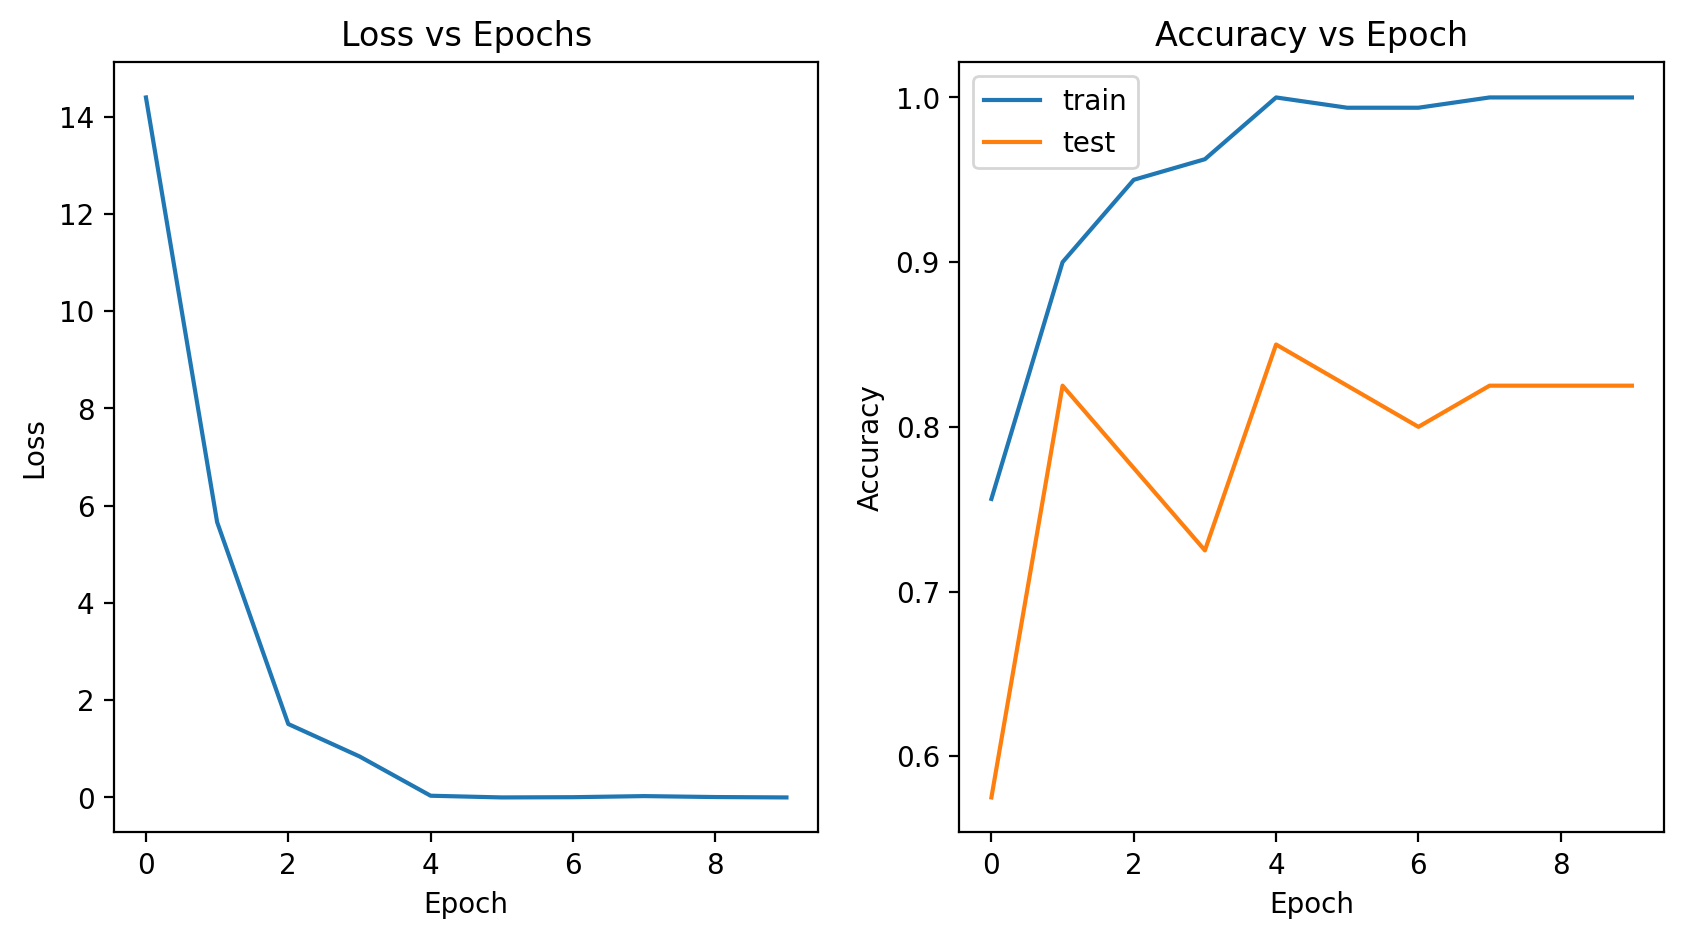

In [37]:
plot_data(vgg1b_items)

# VGG (3 Block)

### Define Model Architecture

In [17]:
class vgg_3_block(nn.Module):
    def __init__(self):
        super(vgg_3_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

vgg3b = vgg_3_block().to(device)
print(vgg3b)
print(f"Number of trainiable parameters: {sum(p.numel() for p in vgg3b.parameters() if p.requires_grad)}")

vgg_3_block(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of trainiable parameters: 12938690


### Train the model

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3b.parameters(), lr=0.001)
start_time = time.time()
vgg3b_items = train(vgg3b, train_loader, loss_fn, optimizer, device, num_epochs=10, model_name = "vgg3b")
end_time = time.time()
vgg3b_time = end_time - start_time
print(f"Training time: {vgg3b_time}")
vgg3b_test_accuracy = test(vgg3b, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 3 Block = {vgg3b_test_accuracy}")
vgg3b_train_accuracy = test(vgg3b, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 3 Block = {vgg3b_train_accuracy}")
torch.save(vgg3b.state_dict(), 'vgg1b.pt')

Epoch 1/10 Loss: 2.155936765670776 Training Accuracy: 0.7562500000000001 Test Accuracy: 0.675
Epoch 2/10 Loss: 0.5253840208053588 Training Accuracy: 0.8250000000000001 Test Accuracy: 0.775
Epoch 3/10 Loss: 0.3447533488273621 Training Accuracy: 0.90625 Test Accuracy: 0.8500000000000001
Epoch 4/10 Loss: 0.2577026695013046 Training Accuracy: 0.93125 Test Accuracy: 0.8500000000000001
Epoch 5/10 Loss: 0.176794171333313 Training Accuracy: 0.9375 Test Accuracy: 0.8500000000000001
Epoch 6/10 Loss: 0.12274154871702195 Training Accuracy: 0.9750000000000001 Test Accuracy: 0.875
Epoch 7/10 Loss: 0.08673968017101288 Training Accuracy: 0.99375 Test Accuracy: 0.8500000000000001
Epoch 8/10 Loss: 0.08036661520600319 Training Accuracy: 0.99375 Test Accuracy: 0.875
Epoch 9/10 Loss: 0.05290990248322487 Training Accuracy: 1.0 Test Accuracy: 0.8500000000000001
Epoch 10/10 Loss: 0.030350882187485696 Training Accuracy: 1.0 Test Accuracy: 0.875
Training time: 70.83241248130798
Test accuracy of VGG 3 Block = 0.

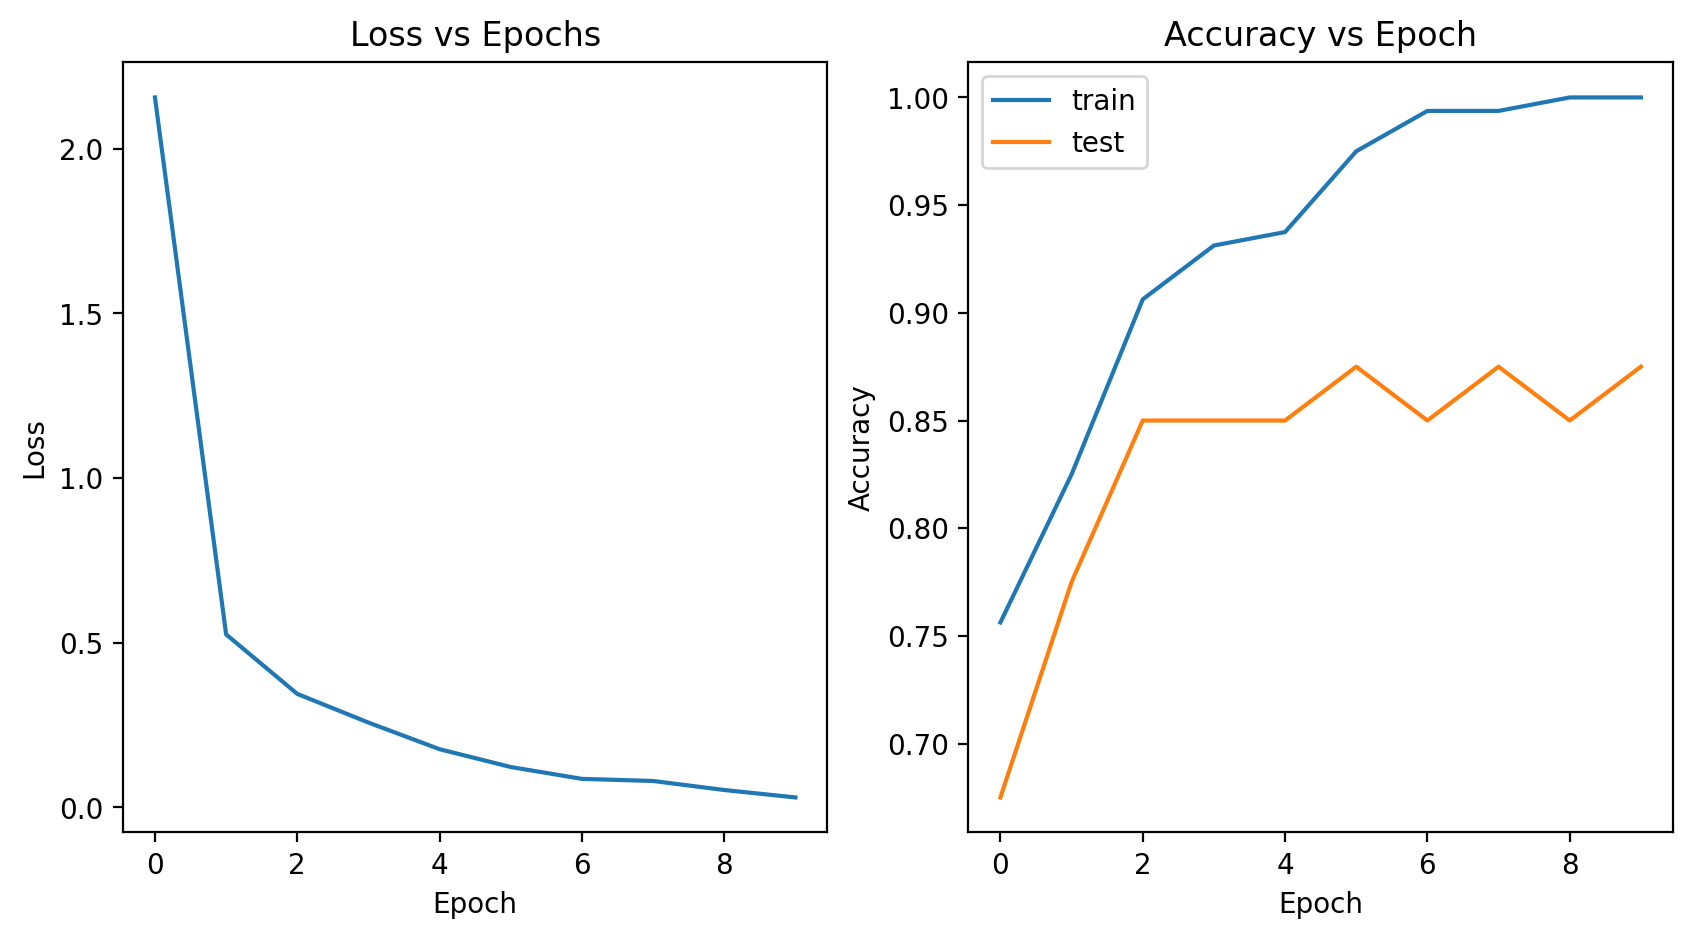

In [19]:
plot_data(vgg3b_items)

# VGG (3 Block) with Data Augmentation

### Create Data Loader with Augmentation

In [24]:
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset_augmented = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Dataset/dataset_horse_vs_panda/train', transform=transform_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

vgg3b_aug = vgg_3_block().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3b_aug.parameters(), lr=0.001)

### Training Model on Augmented Data

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg3b_aug.parameters(), lr=0.001)
start_time = time.time()
vgg3b_aug_items = train(vgg3b_aug, train_loader, loss_fn, optimizer, device, num_epochs=10, model_name = "vgg3b_aug")
end_time = time.time()
vgg3b_aug_time = end_time - start_time
print(f"Training time: {vgg3b_aug_time}")
vgg3b_aug_test_accuracy = test(vgg3b_aug, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 3 Block with data augmentation = {vgg3b_aug_test_accuracy}")
vgg3b_aug_train_accuracy = test(vgg3b_aug, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 3 Block with data augmentation = {vgg3b_aug_train_accuracy}")
torch.save(vgg3b_aug.state_dict(), 'vgg3b_aug.pt')

Epoch 1/10 Loss: 1.8837238430976868 Training Accuracy: 0.80625 Test Accuracy: 0.7250000000000001
Epoch 2/10 Loss: 0.5425550460815429 Training Accuracy: 0.8875000000000001 Test Accuracy: 0.775
Epoch 3/10 Loss: 0.3163605272769928 Training Accuracy: 0.875 Test Accuracy: 0.75
Epoch 4/10 Loss: 0.24687371850013734 Training Accuracy: 0.9125000000000001 Test Accuracy: 0.8500000000000001
Epoch 5/10 Loss: 0.17925645411014557 Training Accuracy: 0.9500000000000001 Test Accuracy: 0.8500000000000001
Epoch 6/10 Loss: 0.11813907027244568 Training Accuracy: 0.9875 Test Accuracy: 0.8500000000000001
Epoch 7/10 Loss: 0.07801814004778862 Training Accuracy: 1.0 Test Accuracy: 0.875
Epoch 8/10 Loss: 0.030482242815196514 Training Accuracy: 1.0 Test Accuracy: 0.8500000000000001
Epoch 9/10 Loss: 0.016433029621839523 Training Accuracy: 1.0 Test Accuracy: 0.9
Epoch 10/10 Loss: 0.006068695057183504 Training Accuracy: 1.0 Test Accuracy: 0.9
Training time: 75.67272710800171
Test accuracy of VGG 3 Block with data aug

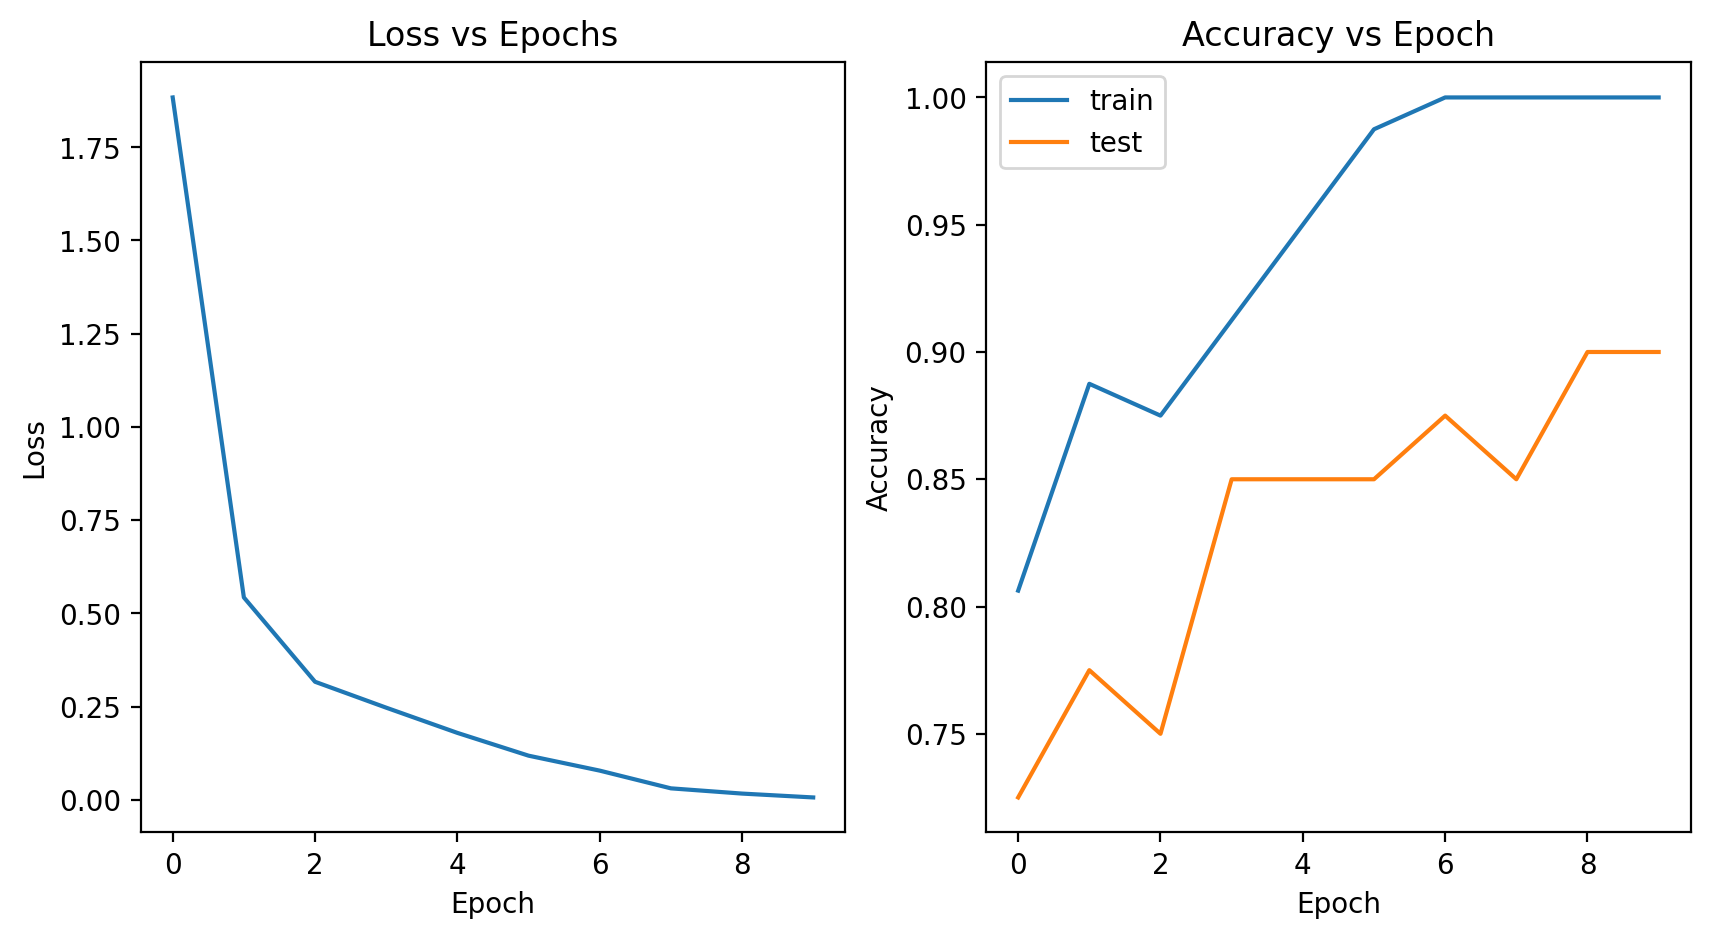

In [26]:
plot_data(vgg3b_aug_items)

# VGG 16

## VGG 16 (Fine-Tuning all layers)

### Setup the model

In [39]:
vgg16_all = models.vgg16(pretrained=True)
vgg16_all.classifier[6] = nn.Linear(4096, 2)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_all.parameters(), lr=0.001)
vgg16_all.to(device)
print(vgg16_all)
vgg16_params = sum(p.numel() for p in vgg16_all.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {vgg16_params}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_all.parameters(), lr=0.001)
start_time = time.time()
vgg16_all_items = train(vgg16_all, train_loader, loss_fn, optimizer, device, num_epochs=25, model_name = "vgg16_all")
end_time = time.time()
vgg16_all_time = end_time - start_time
print(f"Training time: {vgg16_all_time}")
vgg16_all_test_accuracy = test(vgg16_all, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 16 Block with fine-tuning all layers = {vgg16_all_test_accuracy}")
vgg16_all_train_accuracy = test(vgg16_all, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 16 Block with fine-tuning all layers = {vgg16_all_train_accuracy}")
torch.save(vgg16_all.state_dict(), 'vgg16_all.pt')

Epoch 1/25 Loss: 1.268219268321991 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 2/25 Loss: 0.7005175948143005 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 3/25 Loss: 0.6950614333152771 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 4/25 Loss: 0.7479385256767273 Training Accuracy: 0.68125 Test Accuracy: 0.75
Epoch 5/25 Loss: 0.7066476941108704 Training Accuracy: 0.61875 Test Accuracy: 0.6000000000000001
Epoch 6/25 Loss: 0.6481485962867737 Training Accuracy: 0.6875 Test Accuracy: 0.675
Epoch 7/25 Loss: 0.6557996392250061 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 8/25 Loss: 0.6660961270332336 Training Accuracy: 0.71875 Test Accuracy: 0.65
Epoch 9/25 Loss: 0.5924343824386596 Training Accuracy: 0.6937500000000001 Test Accuracy: 0.675
Epoch 10/25 Loss: 0.5809038758277894 Training Accuracy: 0.71875 Test Accuracy: 0.6000000000000001
Epoch 11/25 Loss: 0.5867699325084687 Training Accuracy: 0.5 Test Accuracy: 0.5
Epoch 12/25 Loss: 0.6253775596618653 Training Accuracy: 0.71875 Test Ac

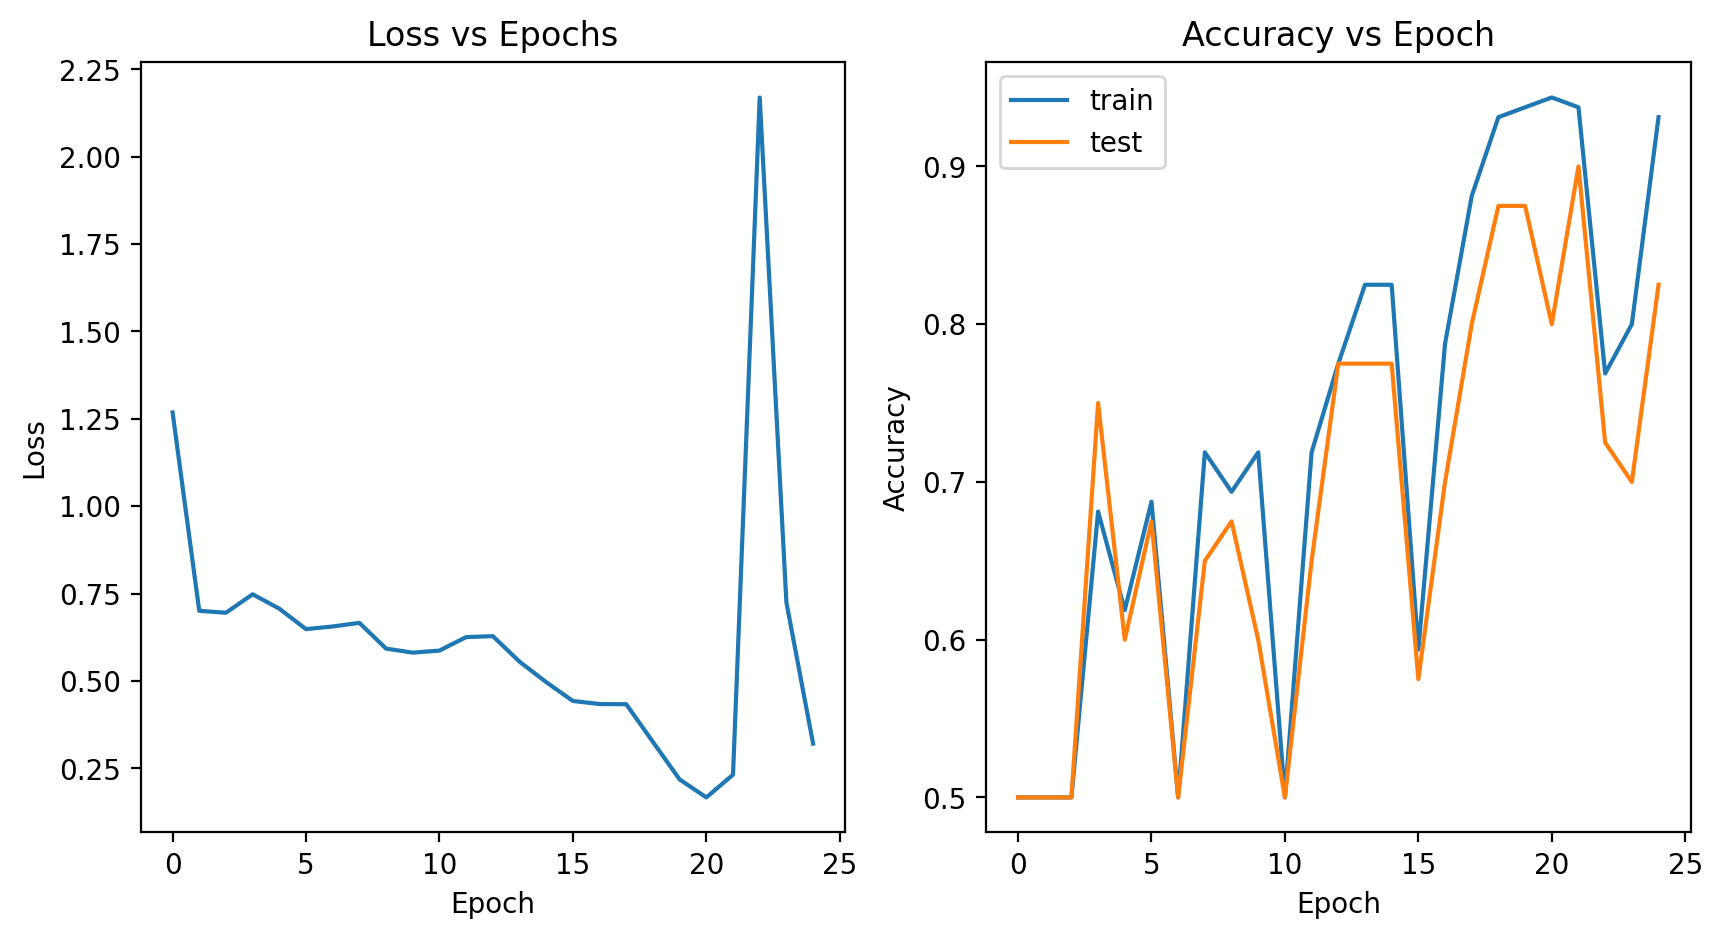

In [42]:
plot_data(vgg16_all_items)

## VGG (16 Block) with Fine-Tuning only Final Layer

### Setup the model

In [43]:
vgg16_final = models.vgg16(pretrained=True)
for param in vgg16_final.parameters():
    param.requires_grad = False
vgg16_final.classifier[6] = nn.Linear(4096, 2)
for param in vgg16_final.classifier[6].parameters():
    param.requires_grad = True
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_final.parameters(), lr=0.001)
vgg16_final.to(device)
print(vgg16_final)
vgg16_params = sum(p.numel() for p in vgg16_final.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {vgg16_params}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_final.parameters(), lr=0.001)
start_time = time.time()
vgg16_final_items = train(vgg16_final, train_loader, loss_fn, optimizer, device, num_epochs=1, model_name = "vgg16_final")
end_time = time.time()
vgg16_final_time = end_time - start_time
print(f"Training time: {vgg16_final_time}")
vgg16_final_test_accuracy = test(vgg16_final, test_loader, loss_fn, device)
print(f"Test accuracy of VGG 16 Block with fine-tuning only final layers = {vgg16_final_test_accuracy}")
vgg16_final_train_accuracy = test(vgg16_final, train_loader, loss_fn, device)
print(f"Train accuracy of VGG 16 Block with fine-tuning only final layers = {vgg16_final_train_accuracy}")
torch.save(vgg16_final.state_dict(), 'vgg16_final.pt')

Epoch 1/1 Loss: 0.01875800876878202 Training Accuracy: 1.0 Test Accuracy: 1.0
Training time: 11.02948808670044
Test accuracy of VGG 16 Block with fine-tuning only final layers = 1.0
Train accuracy of VGG 16 Block with fine-tuning only final layers = 1.0


# Comparing different models

### Training Time

In [52]:
print("Training time for VGG 1:", vgg1b_time)
print("Training time for VGG 3:", vgg3b_time)
print("Training time for VGG 3 with Augmentation:", vgg3b_aug_time)
print("Training time for VGG 16 (Fine-Tuning all layers):", vgg16_all_time)
print("Training time for VGG 16 (Fine-Tuning final layer):", vgg16_final_time)

Training time for VGG 1: 64.08882641792297
Training time for VGG 3: 70.83241248130798
Training time for VGG 3 with Augmentation: 75.67272710800171
Training time for VGG 16 (Fine-Tuning all layers): 336.9397156238556
Training time for VGG 16 (Fine-Tuning final layer): 11.02948808670044


### Training Accuracy

In [47]:
print("Training Accuracy for VGG 1:", vgg1b_train_accuracy)
print("Training Accuracy for VGG 3:", vgg3b_train_accuracy)
print("Training Accuracy for VGG 3 with Augmentation:", vgg3b_aug_train_accuracy)
print("Training Accuracy for VGG 16 (Fine-Tuning all layers):", vgg16_all_train_accuracy)
print("Training Accuracy for VGG 16 (Fine-Tuning final layer):", vgg16_final_train_accuracy)

Training Accuracy for VGG 1: tensor(1., device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 3: tensor(1., device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 3 with Augmentation: tensor(1., device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 16 (Fine-Tuning all layers): tensor(0.9313, device='cuda:0', dtype=torch.float64)
Training Accuracy for VGG 16 (Fine-Tuning final layer): tensor(1., device='cuda:0', dtype=torch.float64)


### Test Accuracy

In [48]:
print("Test Accuracy for VGG 1:", vgg1b_test_accuracy)
print("Test Accuracy for VGG 3:", vgg3b_test_accuracy)
print("Test Accuracy for VGG 3 with Augmentation:", vgg3b_aug_test_accuracy)
print("Test Accuracy for VGG 16 (Fine-Tuning all layers):", vgg16_all_test_accuracy)
print("Test Accuracy for VGG 16 (Fine-Tuning final layer):", vgg16_final_test_accuracy)

Test Accuracy for VGG 1: tensor(0.8250, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 3: tensor(0.8750, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 3 with Augmentation: tensor(0.9000, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 16 (Fine-Tuning all layers): tensor(0.8250, device='cuda:0', dtype=torch.float64)
Test Accuracy for VGG 16 (Fine-Tuning final layer): tensor(1., device='cuda:0', dtype=torch.float64)


### Training Loss

In [53]:
print("Training Loss for VGG 1:", vgg1b_items[0][-1])
print("Training Loss for VGG 3:", vgg3b_items[0][-1])
print("Training Loss for VGG 3 with Augmentation:", vgg3b_aug_items[0][-1])
print("Training Loss for VGG 16 (Fine-Tuning all layers):", vgg16_all_items[0][-1])
print("Training Loss for VGG 16 (Fine-Tuning final layer):", vgg16_final_items[0][-1])

Training Loss for VGG 1: 0.00013083023946478534
Training Loss for VGG 3: 0.030350882187485696
Training Loss for VGG 3 with Augmentation: 0.006068695057183504
Training Loss for VGG 16 (Fine-Tuning all layers): 0.32065611481666567
Training Loss for VGG 16 (Fine-Tuning final layer): 0.01875800876878202


### Number of Parameters

In [50]:
print("Number of parameters in VGG 1:", sum(p.numel() for p in vgg1b.parameters() if p.requires_grad))
print("Number of parameters in VGG 3:", sum(p.numel() for p in vgg3b.parameters() if p.requires_grad))
print("Number of parameters in VGG 3 with Augmentation:", sum(p.numel() for p in vgg3b_aug.parameters() if p.requires_grad))
print("Number of parameters in VGG 16 (Fine-Tuning all layers):", sum(p.numel() for p in vgg16_all.parameters() if p.requires_grad))
print("Number of parameters in VGG 16 (Fine-Tuning final layer):", sum(p.numel() for p in vgg16_final.parameters() if p.requires_grad))

Number of parameters in VGG 1: 51381506
Number of parameters in VGG 3: 12938690
Number of parameters in VGG 3 with Augmentation: 12938690
Number of parameters in VGG 16 (Fine-Tuning all layers): 134268738
Number of parameters in VGG 16 (Fine-Tuning final layer): 8194


# Tabular Statistics
| Model            | Training Time (in sec) | Training Loss | Training Accuracy | Testing Accuracy | Number of Model Parameters |
|------------------|---------------|---------------|-------------------|------------------|----------------------------|
| VGG (1 Block)          |    64.08          |  0.00013083023946478534             |     1.0              |    0.8250              |  51381506                          |
| VGG (3 Block)          |    70.83           |   0.030350882187485696            |    1.0               |   0.8750               |                    12938690        |
| VGG (3 Block) with Augmentation         |    75.67           |       0.006068695057183504        |    1.0               |     0.9000             |        12938690                    |
| VGG16 (Fine-Tuning all Layers)          |    336.93           |        0.32065611481666567       |      0.9313             |   0.8250               |              134268738              |
| VGG16 (Fine-Tuning final layer)          |     11.03          |      0.01875800876878202        |      1.0             |  1.0                |                     8194       |
